In [1]:
from pathlib import Path
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn import model_selection
import numpy as np
import random
import torch 

IS_FIRST_RUN = True

AUGMENT_ROOT = Path("../input/edaugment/aug")
AUGMENT_ROOT_2 = Path("../input/clear-augment/content/audio_train/aug")
TRAIN_ROOT = Path("../input/itmo-acoustic-event-detection-2022/audio_train/train")
TEST_ROOT = Path("../input/itmo-acoustic-event-detection-2022/audio_test")

WORK_DIR = Path("feats")
WORK_DIR.mkdir(exist_ok=True)
PICKLE_DS = WORK_DIR / "../pickle_ds.csv"

SUBMISION_PATH = TEST_ROOT / "../sample_submission.csv"


aug_list = pd.read_csv(AUGMENT_ROOT / "x2augmented.csv")
aug_list["type"] = "aug"
func = lambda x: str(AUGMENT_ROOT / x)
aug_list["fname"] = aug_list.fname.apply(func)

aug_list_2 = pd.read_csv("../input/clear-augment/content/aug.csv")
aug_list_2["type"] = "aug"
aug_list_2["label"] = aug_list_2["label"].apply(lambda x: x[3:-3])
func = lambda x: str(AUGMENT_ROOT_2 / x)
aug_list_2["fname"] = aug_list_2.fname.apply(func)

train_list = pd.read_csv(TRAIN_ROOT / "../../train.csv")
train_list["type"] = "orig"
func = lambda x: str(TRAIN_ROOT / x)
train_list["fname"] = train_list.fname.apply(func)

print(f"Train : {train_list.shape[0]} files")
print(f"Augment : {aug_list.shape[0]} files")
print(f"Augment : {aug_list_2.shape[0]} files")

# dataset = pd.concat((train_list), ignore_index=True)
dataset = train_list

label_transformer = OrdinalEncoder()
dataset["int_label"] = label_transformer.fit_transform(dataset.label.to_numpy()[:, np.newaxis])[:, 0].astype(int)

submission = pd.read_csv(SUBMISION_PATH)
submission["name"] = submission["fname"]
func = lambda x: str(TEST_ROOT/"test" / x)
submission["fname"] = submission.fname.apply(func)
submission["int_label"] = -1
submission["type"] = "orig"

Train : 5683 files
Augment : 5980 files
Augment : 4100 files


In [2]:
import torch
import torchaudio
from torch.utils.data import Dataset
import pickle
import torchaudio.transforms as T

class EventDetectionDataset(Dataset):

    def __init__(self, feats_list, feats_len, need_augment=True):
        self.feats = []
        self.labels = []
        self.feats_len = feats_len
        for feats, label in feats_list:
            self.feats.append(feats)
            self.labels.append(label)
        self.labels = torch.Tensor(self.labels).long()
        self.n_samples = len(self.feats)
        self.aug = need_augment
        
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, idx):
        with open(self.feats[idx], "rb") as f:
            feats = pickle.load(f)
        if feats.shape[1] > self.feats_len:
            feats = feats[:, :self.feats_len]
        else:
#             tmp = np.zeros((128, self.feats_len))
#             tmp[:, :feats.shape[1]] = feats
#             feats = tmp
            feats = [feats for _ in range(int(self.feats_len / feats.shape[1]) + 1)]
            feats = np.concatenate(feats, axis=1)[:, :self.feats_len]
        feats = np.nan_to_num(feats, copy=True, nan=0.0, posinf=10, neginf=-10)
        feats = torch.from_numpy(feats).float()
    
        if np.random.uniform() < 0.05 and self.aug:
            feats = self.masking(feats)
        return feats[None, :, :], self.labels[idx]

    @staticmethod
    def train_test_split(files_list, train_len_feats=300, test_len_feats=2000, 
                           train_size=0.7, feats_dir=WORK_DIR, need_feets=True):
        out_ds = []
        feats_train = []
        feats_test = []
        labels = files_list.int_label.unique()
        for label in labels:
            scope = files_list[files_list.int_label == label]
            n_test_items = int(scope.shape[0] * (1 - train_size))
            for idx, row in scope.iterrows():
                if "_SC%" in row.fname:
                    continue
                feats_list = feats_train
                if np.random.uniform() > train_size:
                    n_test_items -= 1
                    feats_list = feats_test
                if need_feets:
                    feats = EventDetectionDataset.get_feats(*torchaudio.load(row.fname)).numpy()
                    if feats.shape[1] == 0:
                        continue
                    out_feats_d =  feats_dir / Path(row.fname).name
                    with open(out_feats_d, "wb") as f:
                        pickle.dump(feats, f)
                else:
                    out_feats_d =  feats_dir / Path(row.fname).name
                
                feats_list.append((out_feats_d, row.int_label))
                
                tmp = {
                    "pikle" : str(out_feats_d),
                    "label" : row.label,
                    "int_label": row.int_label,
                    "type" : row.type
                }
                out_ds.append(tmp)
        
        out_ds = pd.DataFrame(out_ds)
        train_dataset = EventDetectionDataset(feats_train, train_len_feats)
        test_dataset = EventDetectionDataset(feats_test, test_len_feats, need_augment=False)
        return train_dataset, test_dataset, out_ds
    
    @staticmethod
    def get_feats(wav, sr):
        melSpec = torchaudio.transforms.MelSpectrogram(sr)
        spec = torch.log(melSpec(wav))
        
        return spec[0]
    def masking(self, feats):
        if np.random.uniform() > 0.5:
            x_start = np.random.randint(0, feats.shape[0]//2)
            x_end = np.random.randint(x_start, feats.shape[0]//2) * np.random.randint(1, 2)
            x_start = x_start * np.random.randint(1, 2)
            feats[x_start:x_end] = 0
        else:
            y_start = np.random.randint(0, feats.shape[1]//2)
            y_end = np.random.randint(y_start, feats.shape[1]//2) * np.random.randint(1, 2)
            y_start = y_start * np.random.randint(1, 2)
            feats[:, y_start:y_end] = 0
        return feats

In [3]:
%timeit
np.random.seed(42)
from copy import deepcopy
# dataset = dataset[dataset["type"] == "orig"]
train_ds, test_ds, new_ds = EventDetectionDataset.train_test_split(dataset,
                                                                   train_len_feats=200,
                                                                   test_len_feats=300,
                                                                   train_size=0.8, 
                                                                   need_feets=IS_FIRST_RUN)

IS_FIRST_RUN = False

/opt/conda/lib/python3.7/site-packages/torchaudio/functional/functional.py:508: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "


In [4]:
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import math

def weights_init_normal(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_uniform_(m.weight.data,nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
        # ...
    elif isinstance(m, nn.BatchNorm2d):
        # nn.init.constant_(m.weight.data, 1)
        # nn.init.constant_(m.bias.data, 0)
        ...
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight.data)
        nn.init.constant_(m.bias.data, 0)
class AAMSoftmaxLoss(nn.Module):
    # Additive angular margin softmax loss

    def __init__(self, nOut, nClasses, margin=0.3, scale=15, easy_margin=False, **kwargs):
        super(AAMSoftmaxLoss, self).__init__()

        self.test_normalize = True
        
        self.m = margin
        self.s = scale
        self.in_feats = nOut
        self.weight = nn.Parameter(torch.FloatTensor(nClasses, nOut), requires_grad=True)
        self.ce = nn.CrossEntropyLoss()
        
        nn.init.xavier_normal_(self.weight, gain=1)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(self.m)
        self.sin_m = math.sin(self.m)

        # Make the function cos(theta+m) monotonic decreasing while theta in [0°, 180°]
        self.th = math.cos(math.pi - self.m)
        self.mm = math.sin(math.pi - self.m)*self.m

        print('Initialised AAM softmax margin %.3f scale %.3f.'%(self.m,self.s))

    def forward(self, x, label=None):

        assert x.size()[0] == label.size()[0]
        assert x.size()[1] == self.in_feats
        
        # cos(theta)
        cosine = F.linear(F.normalize(x), F.normalize(self.weight))
        
        # cos(theta + m)
        sine = torch.sqrt((1.0 - torch.mul(cosine, cosine)).clamp(0, 1))
        phi = cosine*self.cos_m - sine*self.sin_m

        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        
        else:
            phi = torch.where((cosine - self.th) > 0, phi, cosine - self.mm)

        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, label.view(-1, 1), 1)
        output = (one_hot*phi) + ((1.0 - one_hot)*cosine)
        output = output*self.s

        loss   = self.ce(output, label)
        prec1  = cosine.detach()
        
        return loss, prec1
    
class MaxOut(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MaxOut, self).__init__()
        self.left = nn.Linear(input_dim, output_dim)
        self.left_norm = nn.BatchNorm1d(output_dim)
        self.right = nn.Linear(input_dim, output_dim)
        self.right_norm = nn.BatchNorm1d(output_dim)
    
    def forward(self, x):
        left = self.left(x)
        left = self.left_norm(left)
        right = self.right(x)
        right = self.right_norm(right)
        
        out = torch.max(left, right)
        return out
        
class EDResNet(nn.Module):
  
    def __init__(self, n_classes=41):
        super(EDResNet, self).__init__()
        
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, padding=1)
        self.cnn1.apply(weights_init_normal)
#         self.norm1 = nn.BatchNorm2d(10)
        
#         self.cnn2 = nn.Conv2d(in_channels=10, out_channels=3, kernel_size=3, padding=1)
#         self.cnn2.apply(weights_init_normal)
        self.norm2 = nn.BatchNorm2d(3)
        
#         self.feats = torch.hub.load("pytorch/vision:v0.10.0", "mnasnet0_5", pretrained=True)
        self.feats = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
#         self.feats = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
#         self.feats = EfficientNet.from_pretrained('efficientnet-b0')
        self.feats.requires_grad_(False)
        
#         conv1 = nn.Sequential(
#             nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, 
#                           padding=3, stride=2, bias=False),
#             nn.Dropout(0.1)
#         )
#         conv1.apply(weights_init_normal)

#         fc = nn.Sequential(
#             nn.Dropout(0.2, inplace=True),
#             nn.Linear(1280, 512)
#         )
        fc = MaxOut(1280, 512)

        fc.apply(weights_init_normal)

#         self.feats.conv1 = conv1
#         self.feats.conv1.requires_grad_(True)

        self.feats.classifier = fc
        self.feats.classifier.requires_grad_(True)
#         self.feats.fc = fc
#         self.feats.fc.requires_grad_(True)

    def forward(self, x):
        
#         preprocessor
        x = self.cnn1(x)
#         x = F.relu(x)
        
#         x = self.cnn2(x)
        x = F.relu(self.norm2(x))

        # feats
        x = self.feats(x)
#         x = F.relu(self.norm3(x))
        x = x.view(x.shape[0], -1)
        return x


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Torch_model = WORK_DIR / "../model.pt"

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True

model = EDResNet()
model.to(device);

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

In [6]:
f1_max = 0
acc_max = 0

In [7]:
from torch.utils.data import DataLoader


# loss_fn = nn.CrossEntropyLoss()
loss_fn = AAMSoftmaxLoss(512, 41).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.003, weight_decay=0.0001)

epoches = 60
batch_size = 128

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, 
                          drop_last=True)
test_loader = DataLoader(test_ds, batch_size=128, shuffle=True)

steps_per_epoch = int(np.ceil(len(train_loader.dataset) / batch_size))


sheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.97)


loss_curve = []
f1_curve = []
acc_curve = []

long_f1_curve = []
long_acc_curve = []

train_f1_curve = []
train_acc_curve = []

lr_curve = []
test_loss_curve = []


Initialised AAM softmax margin 0.300 scale 15.000.


  2%|▏         | 1/60 [00:15<15:02, 15.29s/it]

Last F1 test 0.4664933470593861 : Last F1 train 0.3700175909883696 : Train loss 6.189143003736223 : Test loss 5.661709043714735


  3%|▎         | 2/60 [00:24<11:08, 11.53s/it]

Last F1 test 0.5404604076805151 : Last F1 train 0.6360403728426938 : Train loss 4.375991712297712 : Test loss 5.01820182800293


  5%|▌         | 3/60 [00:32<09:43, 10.23s/it]

Last F1 test 0.545115995714486 : Last F1 train 0.7250696958351949 : Train loss 3.696674306052072 : Test loss 5.02704217698839


  7%|▋         | 4/60 [00:41<08:58,  9.61s/it]

Last F1 test 0.568108596735454 : Last F1 train 0.7798874809275496 : Train loss 3.2882903371538434 : Test loss 4.847502284579807


  8%|▊         | 5/60 [00:50<08:29,  9.27s/it]

Last F1 test 0.5701115350782007 : Last F1 train 0.8236287785517744 : Train loss 2.9072681971958705 : Test loss 4.916276031070286


 10%|█         | 6/60 [00:59<08:12,  9.12s/it]

Last F1 test 0.5695902672125162 : Last F1 train 0.8587676297714031 : Train loss 2.5699147190366474 : Test loss 4.831539789835612


 12%|█▏        | 7/60 [01:09<08:31,  9.65s/it]

Last F1 test 0.4609818038821835 : Last F1 train 0.4149137969632294 : Train loss 5.778903811318534 : Test loss 5.296030892266168


 13%|█▎        | 8/60 [01:20<08:36,  9.94s/it]

Last F1 test 0.53646794808651 : Last F1 train 0.6420406329128352 : Train loss 3.8494235447474887 : Test loss 4.439804289076063


 15%|█▌        | 9/60 [01:31<08:42, 10.25s/it]

Last F1 test 0.6084347133163144 : Last F1 train 0.6848552324193785 : Train loss 3.3028341225215367 : Test loss 4.0015157328711615


 17%|█▋        | 10/60 [01:41<08:39, 10.38s/it]

Last F1 test 0.623033435862533 : Last F1 train 0.7439182024970564 : Train loss 2.734001248223441 : Test loss 3.9429484473334417


 18%|█▊        | 11/60 [01:52<08:33, 10.48s/it]

Last F1 test 0.6719345256983218 : Last F1 train 0.7995666516580656 : Train loss 2.2074866907937185 : Test loss 3.807314051522149


 20%|██        | 12/60 [02:03<08:27, 10.58s/it]

Last F1 test 0.5999739069698486 : Last F1 train 0.8169504956401462 : Train loss 2.052350378036499 : Test loss 4.101943757798937


 22%|██▏       | 13/60 [02:14<08:18, 10.60s/it]

Last F1 test 0.6828650912235505 : Last F1 train 0.8406069085282363 : Train loss 1.7820607968739102 : Test loss 3.373532851537069


 23%|██▎       | 14/60 [02:24<08:07, 10.60s/it]

Last F1 test 0.6482222717000163 : Last F1 train 0.8710951436864404 : Train loss 1.4565951211111887 : Test loss 3.9740109973483615


 25%|██▌       | 15/60 [02:35<08:04, 10.76s/it]

Last F1 test 0.730801617324117 : Last F1 train 0.8837828584124904 : Train loss 1.3155741947037833 : Test loss 2.989163637161255


 27%|██▋       | 16/60 [02:46<07:52, 10.74s/it]

Last F1 test 0.7391079401164016 : Last F1 train 0.9044397878275827 : Train loss 1.0839936460767474 : Test loss 2.9975046846601696


 28%|██▊       | 17/60 [02:57<07:40, 10.71s/it]

Last F1 test 0.7055232008132747 : Last F1 train 0.9162746463837903 : Train loss 0.9788673528603145 : Test loss 3.256298859914144


 30%|███       | 18/60 [03:07<07:29, 10.70s/it]

Last F1 test 0.7319495209385338 : Last F1 train 0.9205737363701864 : Train loss 0.8757238788264138 : Test loss 2.9880998929341636


 32%|███▏      | 19/60 [03:18<07:20, 10.74s/it]

Last F1 test 0.7479284683932111 : Last F1 train 0.9451809288286319 : Train loss 0.6775542574269431 : Test loss 2.8400797843933105


 33%|███▎      | 20/60 [03:29<07:07, 10.70s/it]

Last F1 test 0.7712522837703834 : Last F1 train 0.9491144070914528 : Train loss 0.6022690049239567 : Test loss 2.5622098445892334


 35%|███▌      | 21/60 [03:39<06:55, 10.64s/it]

Last F1 test 0.7598916082245766 : Last F1 train 0.9502812682307917 : Train loss 0.5417832046747207 : Test loss 2.709399117363824


 37%|███▋      | 22/60 [03:50<06:44, 10.64s/it]

Last F1 test 0.7413273418062831 : Last F1 train 0.9550554184727036 : Train loss 0.5062660447188786 : Test loss 2.9059378835890026


 38%|███▊      | 23/60 [04:00<06:31, 10.59s/it]

Last F1 test 0.7684484900319996 : Last F1 train 0.9647272665875392 : Train loss 0.4364182016679219 : Test loss 2.6019303533766003


 40%|████      | 24/60 [04:11<06:20, 10.57s/it]

Last F1 test 0.7695667065216745 : Last F1 train 0.9741054467752401 : Train loss 0.31869491658040455 : Test loss 2.687155101034376


 42%|████▏     | 25/60 [04:22<06:11, 10.61s/it]

Last F1 test 0.7729402290807492 : Last F1 train 0.9763441155748805 : Train loss 0.3098932320518153 : Test loss 2.6250645319620767


 43%|████▎     | 26/60 [04:32<05:59, 10.57s/it]

Last F1 test 0.7676609302774109 : Last F1 train 0.9783326569941545 : Train loss 0.2769446096249989 : Test loss 2.6130968199835882


 45%|████▌     | 27/60 [04:43<05:48, 10.55s/it]

Last F1 test 0.7659930641018926 : Last F1 train 0.980161338406195 : Train loss 0.24201987619910922 : Test loss 2.6134304205576577


 47%|████▋     | 28/60 [04:53<05:37, 10.55s/it]

Last F1 test 0.7604729377367715 : Last F1 train 0.9832731244721722 : Train loss 0.22580935103552682 : Test loss 2.900580962498983


 48%|████▊     | 29/60 [05:04<05:26, 10.53s/it]

Last F1 test 0.7595394817135556 : Last F1 train 0.9787748948568402 : Train loss 0.2539928342614855 : Test loss 2.7742359108395047


 50%|█████     | 30/60 [05:14<05:15, 10.52s/it]

Last F1 test 0.7719981102693578 : Last F1 train 0.9870429667433486 : Train loss 0.16654975999678884 : Test loss 2.624017741945055


 52%|█████▏    | 31/60 [05:25<05:06, 10.57s/it]

Last F1 test 0.7815539409517408 : Last F1 train 0.9888563490908296 : Train loss 0.15629090879644666 : Test loss 2.636908027860853


 53%|█████▎    | 32/60 [05:35<04:55, 10.55s/it]

Last F1 test 0.7616591137700341 : Last F1 train 0.9870588624986173 : Train loss 0.1658664020044463 : Test loss 2.7386437786950006


 55%|█████▌    | 33/60 [05:46<04:44, 10.55s/it]

Last F1 test 0.7837113576019006 : Last F1 train 0.9910741123138908 : Train loss 0.12737488374114037 : Test loss 2.5479784276750355


 57%|█████▋    | 34/60 [05:56<04:34, 10.57s/it]

Last F1 test 0.7861918895224109 : Last F1 train 0.9913055321344042 : Train loss 0.1129578122869134 : Test loss 2.4192799727121987


 58%|█████▊    | 35/60 [06:07<04:23, 10.56s/it]

Last F1 test 0.7875071703630138 : Last F1 train 0.9939762684992224 : Train loss 0.08471064930781722 : Test loss 2.4436894920137195


 60%|██████    | 36/60 [06:18<04:13, 10.55s/it]

Last F1 test 0.7980507412469169 : Last F1 train 0.9950858171228242 : Train loss 0.07414810922262924 : Test loss 2.4147745768229165


 62%|██████▏   | 37/60 [06:28<04:02, 10.56s/it]

Last F1 test 0.7892095422029557 : Last F1 train 0.9968742979070815 : Train loss 0.05160146760089057 : Test loss 2.4226618342929416


 63%|██████▎   | 38/60 [06:39<03:52, 10.58s/it]

Last F1 test 0.7850752160780132 : Last F1 train 0.9955419649045781 : Train loss 0.06280205712786742 : Test loss 2.466549184587267


 65%|██████▌   | 39/60 [06:49<03:42, 10.58s/it]

Last F1 test 0.8025927920924854 : Last F1 train 0.9950987654011249 : Train loss 0.07622094774352653 : Test loss 2.4027515252431235


 67%|██████▋   | 40/60 [07:00<03:31, 10.59s/it]

Last F1 test 0.7952495394089958 : Last F1 train 0.9957599630516591 : Train loss 0.06330695314598934 : Test loss 2.401976373460558


 68%|██████▊   | 41/60 [07:11<03:21, 10.59s/it]

Last F1 test 0.8088199844471253 : Last F1 train 0.9975406896734116 : Train loss 0.04749411264700549 : Test loss 2.234807637002733


 70%|███████   | 42/60 [07:21<03:10, 10.56s/it]

Last F1 test 0.8076598610148428 : Last F1 train 0.9982136952631978 : Train loss 0.03279189937748015 : Test loss 2.283287856313917


 72%|███████▏  | 43/60 [07:32<02:59, 10.57s/it]

Last F1 test 0.8115880109433322 : Last F1 train 0.9979902671790545 : Train loss 0.029781826339395984 : Test loss 2.2270606491300793


 73%|███████▎  | 44/60 [07:42<02:49, 10.61s/it]

Last F1 test 0.8058107276353462 : Last F1 train 0.9979897388193206 : Train loss 0.0313397801714018 : Test loss 2.288216577635871


 75%|███████▌  | 45/60 [07:53<02:38, 10.56s/it]

Last F1 test 0.807884704215658 : Last F1 train 0.9968735666116659 : Train loss 0.04183944116479584 : Test loss 2.3075039784113565


 77%|███████▋  | 46/60 [08:03<02:27, 10.55s/it]

Last F1 test 0.8005341471269515 : Last F1 train 0.9979921909447388 : Train loss 0.03559227776048439 : Test loss 2.397665950987074


 78%|███████▊  | 47/60 [08:14<02:17, 10.58s/it]

Last F1 test 0.8130311913541203 : Last F1 train 0.9975449885933878 : Train loss 0.02931747982012374 : Test loss 2.2385335895750256


 80%|████████  | 48/60 [08:25<02:07, 10.59s/it]

Last F1 test 0.8164485495833347 : Last F1 train 0.9986599078085252 : Train loss 0.025155827928600567 : Test loss 2.196690652105543


 82%|████████▏ | 49/60 [08:35<01:56, 10.56s/it]

Last F1 test 0.8036241650734154 : Last F1 train 0.9982147993249352 : Train loss 0.026202928580875907 : Test loss 2.324049631754557


 83%|████████▎ | 50/60 [08:46<01:45, 10.57s/it]

Last F1 test 0.7959510146757836 : Last F1 train 0.997541629982069 : Train loss 0.03464958060898685 : Test loss 2.466657373640272


 85%|████████▌ | 51/60 [08:56<01:34, 10.55s/it]

Last F1 test 0.808977750922845 : Last F1 train 0.9982140673586631 : Train loss 0.0328776109298425 : Test loss 2.2842793332205877


 87%|████████▋ | 52/60 [09:07<01:24, 10.52s/it]

Last F1 test 0.8071920137965093 : Last F1 train 0.9975458352042945 : Train loss 0.03769596895602133 : Test loss 2.333862370914883


 88%|████████▊ | 53/60 [09:17<01:13, 10.54s/it]

Last F1 test 0.7972028472104149 : Last F1 train 0.996650650466002 : Train loss 0.044142603731182006 : Test loss 2.451691826184591


 90%|█████████ | 54/60 [09:28<01:03, 10.52s/it]

Last F1 test 0.7907076190911355 : Last F1 train 0.9975471956498164 : Train loss 0.03889816150601421 : Test loss 2.572270817226834


 92%|█████████▏| 55/60 [09:38<00:52, 10.50s/it]

Last F1 test 0.7904578199861122 : Last F1 train 0.9984358818072936 : Train loss 0.03186292489657977 : Test loss 2.4570455816056995


 93%|█████████▎| 56/60 [09:49<00:42, 10.57s/it]

Last F1 test 0.8084671118024235 : Last F1 train 0.998216925285112 : Train loss 0.03261599318523492 : Test loss 2.296158936288622


 95%|█████████▌| 57/60 [09:59<00:31, 10.55s/it]

Last F1 test 0.8012325939569682 : Last F1 train 0.997544305667347 : Train loss 0.037918761472350786 : Test loss 2.3567464616563587


 97%|█████████▋| 58/60 [10:10<00:21, 10.55s/it]

Last F1 test 0.7949315589964979 : Last F1 train 0.9979925619730168 : Train loss 0.03073931759489434 : Test loss 2.4363384776645236


 98%|█████████▊| 59/60 [10:21<00:10, 10.59s/it]

Last F1 test 0.7962524412646481 : Last F1 train 0.9977666729413938 : Train loss 0.032346867111378484 : Test loss 2.4715307818518744


100%|██████████| 60/60 [10:31<00:00, 10.53s/it]

Last F1 test 0.8025144731586318 : Last F1 train 0.9977750434589672 : Train loss 0.032659807541806786 : Test loss 2.3813985188802085


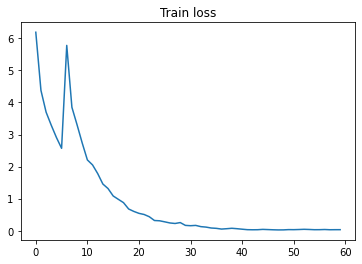

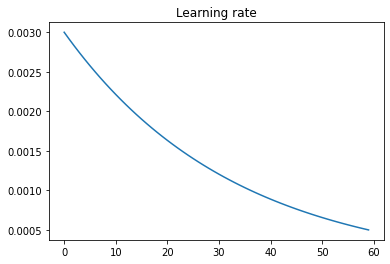

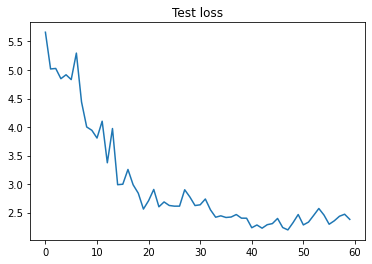

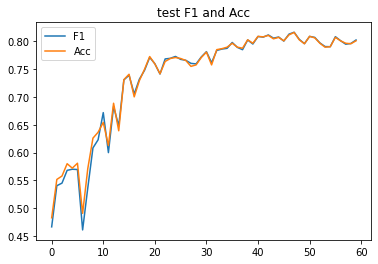

Max Acc : 0.8160919540229885, on 47
Max F1 : 0.8164485495833347 on 47


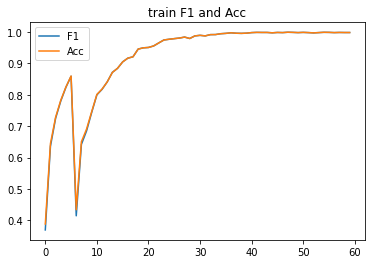

In [8]:
from tqdm import tqdm
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt


for epoch in tqdm(range(epoches)):
    if epoch > 5:
        model.feats.requires_grad_(True)
# ----------------------------------------------------- TRAIN
    model.train()
    predicted, true,  loss_in_batch = [], [], []
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)

        pred_t = model(X)
        loss, tar = loss_fn(pred_t, y)
#         loss = loss_fn(pred_t, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_in_batch.append(loss.item())
        
        predicted.append(tar.detach().cpu().numpy().argmax(axis=-1))
#         predicted.append(pred_t.detach().cpu().numpy().argmax(axis=-1))
        true.append(y.detach().cpu().numpy())
    
    lr_curve.append(sheduler.get_last_lr())
    sheduler.step()
    
    loss_curve.append(sum(loss_in_batch)/len(loss_in_batch))
    predicted, true  = np.concatenate(predicted), np.concatenate(true)

    train_f1_curve.append(f1_score(true, predicted, average="weighted"))
    train_acc_curve.append(accuracy_score(true, predicted))
# ----------------------------------------------------------------TEST    
    model.eval()
    with torch.no_grad():
        predicted, true,  loss_in_batch = [], [], []
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            
            pred_t = model(X)
            loss, tar = loss_fn(pred_t, y)
#             loss = loss_fn(pred_t, y)
            loss_in_batch.append(loss.item()) 
        
            predicted.append(tar.detach().cpu().numpy().argmax(axis=-1))
#             predicted.append(pred_t.detach().cpu().numpy().argmax(axis=-1))
            true.append(y.detach().cpu().numpy())
        
        test_loss_curve.append(sum(loss_in_batch)/len(loss_in_batch))
    
    predicted, true  = np.concatenate(predicted), np.concatenate(true)

    f1_curve.append(f1_score(true, predicted, average="weighted"))
    acc_curve.append(accuracy_score(true, predicted))
    
    print(f"Last F1 test {f1_curve[-1]} : Last F1 train {train_f1_curve[-1]} : Train loss {loss_curve[-1]} : Test loss {test_loss_curve[-1]}")
    if f1_curve[-1] > f1_max or acc_curve[-1] > acc_max:
        f1_max = f1_curve[-1]
        acc_max = acc_curve[-1]
        torch.save(model.state_dict(), Torch_model)
    
    
    
plt.plot(loss_curve)
plt.title("Train loss")
plt.show()

plt.plot(lr_curve)
plt.title("Learning rate")
plt.show()

plt.plot(test_loss_curve)
plt.title("Test loss")
plt.show()

plt.plot(f1_curve, label="F1")
plt.plot(acc_curve, label="Acc")
plt.title("test F1 and Acc")
plt.legend()
plt.show()

plt.plot(train_f1_curve, label="F1")
plt.plot(train_acc_curve, label="Acc")
plt.title("train F1 and Acc")
plt.legend()

print(f"Max Acc : {max(acc_curve)}, on {acc_curve.index(max(acc_curve))}")
print(f"Max F1 : {max(f1_curve)} on {f1_curve.index(max(f1_curve))}")

In [9]:
del X
del y
del model
import gc
gc.collect()
torch.cuda.empty_cache()

In [10]:
model = EDResNet()
checkpoint = torch.load(Torch_model)
model.load_state_dict(checkpoint)
model.to(device)
model.eval()

SUBMISION_PATH = Path("../input/itmo-acoustic-event-detection-2022/audio_test")
submission = pd.read_csv(SUBMISION_PATH / "../sample_submission.csv")
submission["name"] = submission["fname"]
func = lambda x: str(SUBMISION_PATH / "test" / x)
submission["fname"] = submission.fname.apply(func)
submission["int_label"] = 0
submission["type"] = "orig"
sub_ds, _, _ = EventDetectionDataset.train_test_split(submission,
                                                       train_len_feats=400, 
                                                       train_size=1, 
                                                       need_feets=True)
sub_ds.aug=False
sub_loader = DataLoader(sub_ds, batch_size=2, shuffle=False)
predicted = []
true = []
for X, y in sub_loader:
    X, y = X.to(device), y.to(device)

    pred_t = model(X)
    _, tar = loss_fn(pred_t, y)

    predicted.append(tar.detach().cpu().numpy().argmax(axis=-1))
#     predicted.append(pred_t.detach().cpu().numpy().argmax(axis=-1))

predicted = np.concatenate(predicted)

submission["int_lable"] = predicted
submission["label"] = label_transformer.inverse_transform(submission["int_lable"].to_numpy()[:, np.newaxis])[:, 0]
submission["fname"] = submission["name"]
submission = submission.drop(columns=["name", "int_label", "type", "int_lable"])

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/opt/conda/lib/python3.7/site-packages/torchaudio/functional/functional.py:508: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "


In [11]:
# submission["fname"] = submission["name"]
submission.to_csv("submission.csv", index=False)